# Tweets Analysis

## 1. Import Libraries

In [750]:
import numpy as np
import pandas as pd
from time import time
import warnings
import math
from pyarabic.araby import tokenize, is_arabicrange
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, fbeta_score, accuracy_score, confusion_matrix, roc_curve, auc, plot_roc_curve, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


## 2. Read the Data

In [751]:
tweets = pd.read_csv('Tweets\\tweets_classified.csv')
tweets = tweets.drop(['Unnamed: 0', 'index'], axis=1)
tweets = tweets.reset_index(drop=True)
tweets.head()


,ID,Tweet,Timestamp,Likes,Retweets,Length,Date,Time,Class
0,1497300372569739264,قبيل الاحتفال بـ اليوم الدولي لمراة تستعد كوكب...,2022-02-25 20:00:01+00:00,1,0,198,2022-02-25,20:00:01,positive
1,1497299670522994691,لحظات نزول دابانغ سلمان خان علا ارض المسرح اك...,2022-02-25 19:57:14+00:00,2,0,207,2022-02-25,19:57:14,positive
2,1497297255245754371,ليلة ميزة بانتظارنا الحانها شرقية نجومها است...,2022-02-25 19:47:38+00:00,0,0,232,2022-02-25,19:47:38,positive
3,1497295489481510914,اصدق حفلة احلا فستان مستان انا بختار واذا حفل...,2022-02-25 19:40:37+00:00,3,1,168,2022-02-25,19:40:37,positive
4,1497290589800480779,جنون بعده جنون دابانغ سلمان خان يستعرض حشد كب...,2022-02-25 19:21:09+00:00,5,2,178,2022-02-25,19:21:09,positive


In [752]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7974 entries, 0 to 7973
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         7974 non-null   int64 
 1   Tweet      7974 non-null   object
 2   Timestamp  7974 non-null   object
 3   Likes      7974 non-null   int64 
 4   Retweets   7974 non-null   int64 
 5   Length     7974 non-null   int64 
 6   Date       7974 non-null   object
 7   Time       7974 non-null   object
 8   Class      7974 non-null   object
dtypes: int64(4), object(5)
memory usage: 560.8+ KB


In [753]:
tweets.columns

Index(['ID', 'Tweet', 'Timestamp', 'Likes', 'Retweets', 'Length', 'Date',
       'Time', 'Class'],
      dtype='object')

## 3. Descriptive Statistics

In [754]:
# YOUR CODE HERE

## 4. Predective Statistics

### Data Preprocessing & Feature Extraction

In [755]:
# Split the data into tokens
tweets["Tokens"] = tweets["Tweet"].apply(lambda tweet: tokenize(tweet, conditions=is_arabicrange))

In [756]:
tweets.head()
tweets.tail()

,ID,Tweet,Timestamp,Likes,Retweets,Length,Date,Time,Class,Tokens
7969,1510697936317030406,اغلق معرض اكسبو الامارات اجلته الجاءحة ابوا...,2022-04-03 19:17:10+00:00,9,1,279,2022-04-03,19:17:10,neutral,"[اغلق, معرض, اكسبو, الامارات, اجلته, الجاءحة, ..."
7970,1510688181640962050,اختام معرض اكسبو دبي يومين الخميس فرصة المعرض...,2022-04-03 18:38:24+00:00,1,0,304,2022-04-03,18:38:24,positive,"[اختام, معرض, اكسبو, دبي, يومين, الخميس, فرصة,..."
7971,1510686349417984006,هاشتاق عربي انتهاءه الامارات تكشف عد زوار اكسب...,2022-04-03 18:31:07+00:00,0,0,112,2022-04-03,18:31:07,neutral,"[هاشتاق, عربي, انتهاءه, الامارات, تكشف, عد, زو..."
7972,1510686265649340420,الحمدله انجاز راءع شكرا الامارات الحبيبه نبارك...,2022-04-03 18:30:47+00:00,0,2,160,2022-04-03,18:30:47,positive,"[الحمدله, انجاز, راءع, شكرا, الامارات, الحبيبه..."
7973,1510686095054356487,اكسبو ابرز الارقام القياسية حقها جناح السعودية...,2022-04-03 18:30:06+00:00,0,0,100,2022-04-03,18:30:06,positive,"[اكسبو, ابرز, الارقام, القياسية, حقها, جناح, ا..."


In [757]:
# Drop the neutral class 
tweets = tweets[tweets.Class != 'neutral']
tweets = tweets.reset_index()

In [758]:
# Convert the classes negative and positive to 0 and 1 respectively
tweets['Class'] = tweets['Class'].map({'negative': 0, 'positive': 1})

In [759]:
tweets.head()

,index,ID,Tweet,Timestamp,Likes,Retweets,Length,Date,Time,Class,Tokens
0,0,1497300372569739264,قبيل الاحتفال بـ اليوم الدولي لمراة تستعد كوكب...,2022-02-25 20:00:01+00:00,1,0,198,2022-02-25,20:00:01,1,"[قبيل, الاحتفال, بـ, اليوم, الدولي, لمراة, تست..."
1,1,1497299670522994691,لحظات نزول دابانغ سلمان خان علا ارض المسرح اك...,2022-02-25 19:57:14+00:00,2,0,207,2022-02-25,19:57:14,1,"[لحظات, نزول, دابانغ, سلمان, خان, علا, ارض, ال..."
2,2,1497297255245754371,ليلة ميزة بانتظارنا الحانها شرقية نجومها است...,2022-02-25 19:47:38+00:00,0,0,232,2022-02-25,19:47:38,1,"[ليلة, ميزة, بانتظارنا, الحانها, شرقية, نجومها..."
3,3,1497295489481510914,اصدق حفلة احلا فستان مستان انا بختار واذا حفل...,2022-02-25 19:40:37+00:00,3,1,168,2022-02-25,19:40:37,1,"[اصدق, حفلة, احلا, فستان, مستان, انا, بختار, و..."
4,4,1497290589800480779,جنون بعده جنون دابانغ سلمان خان يستعرض حشد كب...,2022-02-25 19:21:09+00:00,5,2,178,2022-02-25,19:21:09,1,"[جنون, بعده, جنون, دابانغ, سلمان, خان, يستعرض,..."


In [760]:
X = tweets['Tweet']  # features
y = tweets['Class'] # classes

In [761]:
# Convert to a bag of words representation
tfidf = TfidfVectorizer(min_df=1) 
X = tfidf.fit_transform(X)

In [762]:
X

<4847x18163 sparse matrix of type '<class 'numpy.float64'>'
	with 68999 stored elements in Compressed Sparse Row format>

### Split the Data

In [763]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

In [764]:
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))


Training set has 3392 samples.
Testing set has 1455 samples.


### Training Pipeline
The goal is to create a function that trains, scores and predicts any model. This will allow for efficient model selection since we can supply the function with multiple models and compare the results to select the most appropriate one.

#### Function Inputs
> model: the classifier to be trained 
> X_train y_train X_test y_test, X and y
> 
   
#### Function Output
- result which is an array of the prediction time and scores respectively

In [765]:
def train_predict_pipeline(model, X_train, y_train, X_test, y_test, X, y):
    print("            {} Training            ".format(model.__class__.__name__))
    results = {}

    start = time()  # Training start
    model = model.fit(X_train, y_train) # Train the model
    end = time()  # Training end
    results['training_time'] = end - start # Store the time

    start = time()  # Prediction start
    predictions_test = model.predict(X_test) # Predict
    predictions_train = model.predict(X_train[:300])
    end = time()  # Prediction end
    results['prediction_time'] = end - start # Store the time


    results['model_accuracy'] = model.score(X_train, y_train) # Overall accuracy

    # Cross validation score
    cross_validation_scores = cross_val_score(model,X, y, cv=10)
    results['model_cross_validation'] = np.mean(cross_validation_scores) 

    # Accuracy scores - for plotting
    results['accuracy_train'] = accuracy_score(y_train[:300], predictions_train)
    results['accuracy_test'] = accuracy_score(y_test, predictions_test)

    # F-scores
    results['fbeta_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
    results['fbeta_test'] = fbeta_score(y_test, predictions_test, beta=0.5)

    # Print the report
    print('            Accuracy Report            ')
    print('Model Accuracy: %.2f' % results['model_accuracy'])
    print('10-Fold Cross Validation: %.2f' % results['model_cross_validation'])
    print('F-beta Score (Training): %.2f' % results['fbeta_train'])
    print('F-beta Score (Testing): %.2f' % results['fbeta_test'])
    print('            Confusion Matrix            ')
    print(confusion_matrix(y_test, predictions_test))
    print(classification_report(y_test, predictions_test))

    display = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['negative', 'positive'], cmap=plt.cm.Blues)
    display.ax_.set_title('Confusion Matrix Display')
    plt.show()

    # Return the results and the classifier
    return results, model


In [766]:
SVC_classifier = SVC(random_state=0, probability=True)
AdaBoost_classifier = AdaBoostClassifier(random_state=0)
Naivebayes_classifier = BernoulliNB()


            SVC Training            
            Accuracy Report            
Model Accuracy: 0.99
10-Fold Cross Validation: 0.93
F-beta Score (Training): 0.99
F-beta Score (Testing): 0.94
            Confusion Matrix            
[[   9  112]
 [   1 1333]]
              precision    recall  f1-score   support

           0       0.90      0.07      0.14       121
           1       0.92      1.00      0.96      1334

    accuracy                           0.92      1455
   macro avg       0.91      0.54      0.55      1455
weighted avg       0.92      0.92      0.89      1455



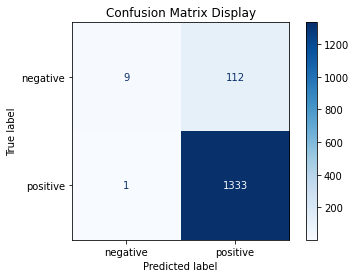

            AdaBoostClassifier Training            
            Accuracy Report            
Model Accuracy: 0.95
10-Fold Cross Validation: 0.93
F-beta Score (Training): 0.95
F-beta Score (Testing): 0.95
            Confusion Matrix            
[[  40   81]
 [  20 1314]]
              precision    recall  f1-score   support

           0       0.67      0.33      0.44       121
           1       0.94      0.99      0.96      1334

    accuracy                           0.93      1455
   macro avg       0.80      0.66      0.70      1455
weighted avg       0.92      0.93      0.92      1455



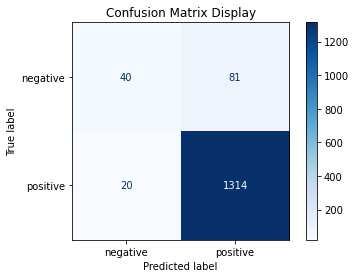

            BernoulliNB Training            
            Accuracy Report            
Model Accuracy: 0.94
10-Fold Cross Validation: 0.93
F-beta Score (Training): 0.94
F-beta Score (Testing): 0.94
            Confusion Matrix            
[[  12  109]
 [   1 1333]]
              precision    recall  f1-score   support

           0       0.92      0.10      0.18       121
           1       0.92      1.00      0.96      1334

    accuracy                           0.92      1455
   macro avg       0.92      0.55      0.57      1455
weighted avg       0.92      0.92      0.90      1455



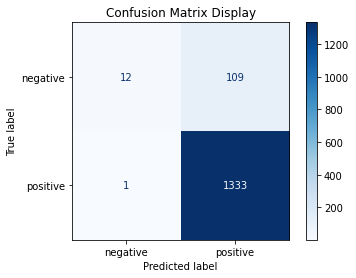

In [767]:
results = {}

for classifier in [SVC_classifier, AdaBoost_classifier, Naivebayes_classifier]:
    classifier_name = classifier.__class__.__name__
    results[classifier_name] = {}
    results[classifier_name], classifier = train_predict_pipeline(classifier, X_train, y_train, X_test, y_test, X, y)


### Model Evaluation

In [768]:
results

{'SVC': {'training_time': 7.22757625579834,
  'prediction_time': 0.7424640655517578,
  'model_accuracy': 0.9920400943396226,
  'model_cross_validation': 0.9261395586606458,
  'accuracy_train': 0.99,
  'accuracy_test': 0.9223367697594502,
  'fbeta_train': 0.9912536443148687,
  'fbeta_test': 0.9368850154624685},
 'AdaBoostClassifier': {'training_time': 3.2250964641571045,
  'prediction_time': 0.03494524955749512,
  'model_accuracy': 0.9540094339622641,
  'model_cross_validation': 0.9339801482491268,
  'accuracy_train': 0.9333333333333333,
  'accuracy_test': 0.9305841924398626,
  'fbeta_train': 0.9498587570621467,
  'fbeta_test': 0.9502458779288399},
 'BernoulliNB': {'training_time': 0.0029921531677246094,
  'prediction_time': 0.004023551940917969,
  'model_accuracy': 0.9386792452830188,
  'model_cross_validation': 0.9308877907472096,
  'accuracy_train': 0.9233333333333333,
  'accuracy_test': 0.9243986254295533,
  'fbeta_train': 0.9366391184573004,
  'fbeta_test': 0.9384680371726274}}

In [769]:
def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.

    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """

    # Create figure
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))

 # Constants
    bar_width = 0.3
    colors = ['#083471', '#1F6EB3', '#56A0CE']

    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['training_time', 'accuracy_train', 'fbeta_train', 'prediction_time', 'accuracy_test', 'fbeta_test']):
            ax[j//3, j % 3].bar(k*bar_width, results[learner]
                                [metric], width=bar_width, color=colors[k])

    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")

    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")

    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y=accuracy, xmin=-0.1, xmax=3.0,
                     linewidth=1, color='k', linestyle='dashed')
    ax[1, 1].axhline(y=accuracy, xmin=-0.1, xmax=3.0,
                     linewidth=1, color='k', linestyle='dashed')
    ax[0, 2].axhline(y=f1, xmin=-0.1, xmax=3.0, linewidth=1,
                     color='k', linestyle='dashed')
    ax[1, 2].axhline(y=f1, xmin=-0.1, xmax=3.0, linewidth=1,
                     color='k', linestyle='dashed')

    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))

    # Create patches for the legend
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color=colors[i], label=learner))
    plt.legend(handles=patches, bbox_to_anchor=(-.80, 2.53),
               loc='upper center', borderaxespad=0., ncol=3, fontsize='x-large')

    # Aesthetics
    plt.suptitle(
        "Performance Metrics for Three Supervised Learning Models", fontsize=16, y=1.10)
    plt.show()


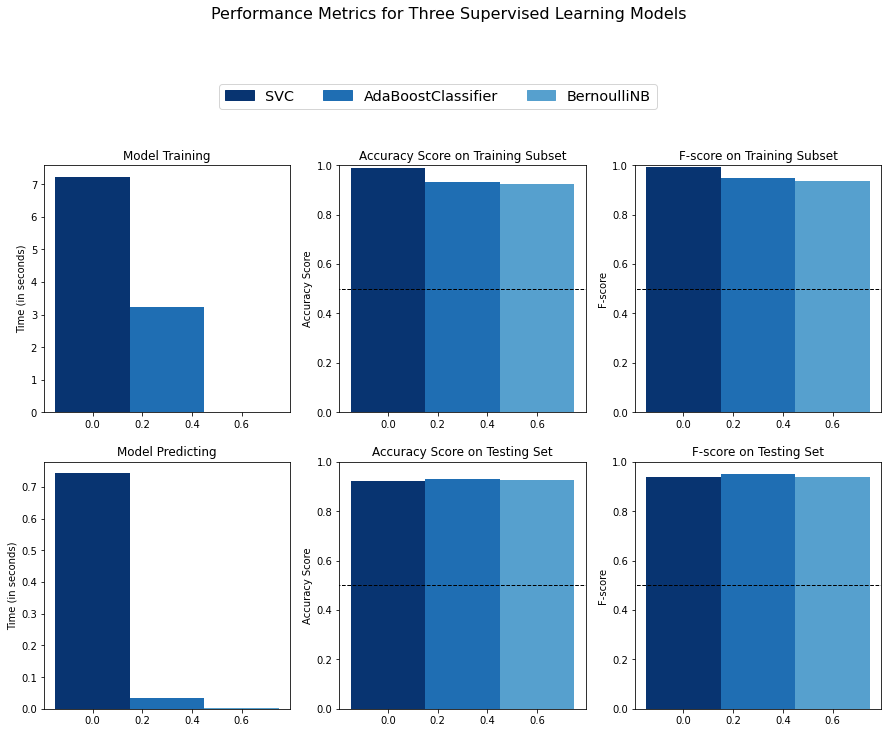

In [770]:
evaluate(results, 0.5, 0.5)


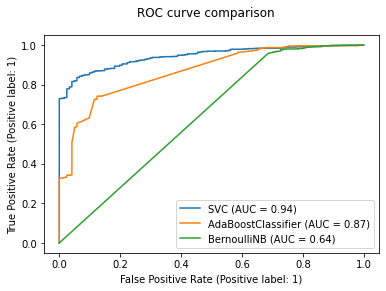

In [771]:
svc_display = plot_roc_curve(SVC_classifier, X_test, y_test)
ada_display = plot_roc_curve(AdaBoost_classifier, X_test, y_test, ax=svc_display.ax_)
naive_display = plot_roc_curve(Naivebayes_classifier, X_test, y_test, ax=ada_display.ax_)
naive_display.figure_.suptitle("ROC curve comparison")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

plt.show()


In [772]:
tfidf.get_feature_names()

['через',
 'ءة',
 'ءه',
 'اا',
 'اب',
 'ابا',
 'اباءهم',
 'ابادة',
 'ابارك',
 'ابتدا',
 'ابتداء',
 'ابتداءا',
 'ابتسامة',
 'ابتسامته',
 'ابتسامتهم',
 'ابتسم',
 'ابتكار',
 'ابتكارا',
 'ابتكارات',
 'ابتكاراتها',
 'ابتكارنا',
 'ابتكاري',
 'ابتكارية',
 'ابتلا',
 'ابتلعت',
 'ابجدية',
 'ابحث',
 'ابحثي',
 'ابخص',
 'ابد',
 'ابدا',
 'ابداء',
 'ابداع',
 'ابداعا',
 'ابداعات',
 'ابداعاته',
 'ابداعك',
 'ابداعهم',
 'ابداعي',
 'ابداعية',
 'ابدع',
 'ابدعت',
 'ابدعتا',
 'ابدعتم',
 'ابدعتو',
 'ابدعنا',
 'ابدعوا',
 'ابراجها',
 'ابراز',
 'ابراهيم',
 'ابرز',
 'ابرزت',
 'ابرزته',
 'ابرزها',
 'ابرزهم',
 'ابرك',
 'ابريل',
 'ابريول',
 'ابسط',
 'ابطال',
 'ابطالنا',
 'ابطالها',
 'ابعتلي',
 'ابعث',
 'ابغا',
 'ابكيتم',
 'ابل',
 'ابلغ',
 'ابن',
 'ابناء',
 'ابناءك',
 'ابناءكم',
 'ابناءنا',
 'ابناءه',
 'ابناءها',
 'ابنة',
 'ابنت',
 'ابنتي',
 'ابنك',
 'ابها',
 'ابهار',
 'ابهارا',
 'ابهر',
 'ابهرت',
 'ابهرتنا',
 'ابهرتونا',
 'ابهرن',
 'ابهرنا',
 'ابهرني',
 'ابو',
 'ابواب',
 'ابوابنا',
 'ابوابه',
 'ابوبدر',
 'ابوراشد',


In [ ]:
feature_names_test_from_train = tf.get_feature_names()
df_test_from_train = pd.DataFrame(
    X_test_from_train.toarray(), columns=feature_names_test_from_train)


In [773]:
test = pd.DataFrame({'Text': ['مميز جدا'],'Class': ['positive']})
test.head()

,Text,Class
0,مميز جدا,positive


In [774]:
tfidf.transform(['مميز جدا'])


<1x18163 sparse matrix of type '<class 'numpy.float64'>'
	with 1 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf.fit_transform(['مميز جدا'])

<1x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [779]:

SVC_classifier.predict(tfidf.transform(['كذب']))


array([1], dtype=int64)

### Fine Tuning